# 15-1. 프로젝트: 더 멋진 번역기 만들기

In [105]:
import pandas as pd 
import tensorflow
import matplotlib

import requests
import tarfile

import tensorflow as tf
import numpy as np

from sklearn.model_selection import train_test_split

import matplotlib.ticker as ticker
import matplotlib.pyplot as plt

import time
import re
import os
import io

from tqdm.notebook import tqdm    # Process 과정을 보기 위해

from tqdm import tqdm    
import random

import matplotlib as mpl
import matplotlib.pyplot as plt

import matplotlib.font_manager as fm

from konlpy.tag import Mecab
import sentencepiece as spm


# Step 1. 데이터 다운로드 (클라우드 유저용)

In [106]:
# !ln -s ~/data ~/aiffel/transformer/data

# Step 2. 데이터 정제 및 토큰화

## 2.1) 중복 제거

In [107]:
data_dir = os.getenv('HOME')+'/aiffel/transformer/data'
kor_path = data_dir+"/korean-english-park.train.ko"
eng_path = data_dir+"/korean-english-park.train.en"

In [108]:
# 데이터 정제 및 토큰화
def clean_corpus(kor_path, eng_path):
    with open(kor_path, "r") as f: 
        kor = f.read().splitlines()
    with open(eng_path, "r") as f: 
        eng = f.read().splitlines()
    assert len(kor) == len(eng) # assert는 뒤의 조건이 True가 아니면 AssertError를 발생한다.
    df = pd.DataFrame({
        'ko': kor,
        'en': eng,
    })
    print('중복 제거 전 :',len(df))
    df = df.drop_duplicates(subset=['ko','en'])
    print('중복 제거 후 :',len(df))

    return df.iloc[:,[0,1]].values

cleaned_corpus = clean_corpus(kor_path, eng_path)

중복 제거 전 : 94123
중복 제거 후 : 78968


## 2.2) 전처리 

- 모든 입력을 소문자로 변환합니다.
- 알파벳, 문장부호, 한글만 남기고 모두 제거합니다.
- 문장부호 양옆에 공백을 추가합니다.
- 문장 앞뒤의 불필요한 공백을 제거합니다.

In [109]:
def preprocess_sentence(sentence):
    # 모든 입력을 소문자로 변환
    sentence = sentence.lower()
    
    # 알파벳, 문장부호, 한글만 남기고 모두 제거
    sentence = re.sub(r'[^a-zA-Z가-힣.,!?\'"\s]', '', sentence)
    
    # 문장부호 양옆에 공백을 추가
    sentence = re.sub(r'([.,!?\'"])', r' \1 ', sentence)
    
    # 문장 앞뒤의 불필요한 공백을 제거
    sentence = sentence.strip()
    
    return sentence

## 2.3) 토큰화

한글 말뭉치 kor_corpus 와 영문 말뭉치 eng_corpus 를 각각 분리한 후, 정제하여 토큰화를 진행합니다! 
토큰화에는 Sentencepiece를 활용하세요. 
첨부된 공식 사이트를 참고해 아래 조건을 만족하는 generate_tokenizer() 함수를 정의합니다. 
최종적으로 ko_tokenizer 과 en_tokenizer 를 얻으세요. en_tokenizer에는 set_encode_extra_options("bos:eos") 함수를 실행해 타겟 입력이 문장의 시작 토큰과 끝 토큰을 포함할 수 있게 합니다.

단어 사전을 매개변수로 받아 원하는 크기의 사전을 정의할 수 있게 합니다. (기본: 20,000)
학습 후 저장된 model 파일을 SentencePieceProcessor() 클래스에 Load()한 후 반환합니다.
특수 토큰의 인덱스를 아래와 동일하게 지정합니다.
<PAD> : 0 / <BOS> : 1 / <EOS> : 2 / <UNK> : 3

In [110]:
# Sentencepiece를 활용하여 학습한 tokenizer를 생성합니다.
def generate_tokenizer_train(corpus,
                        vocab_size,
                        lang="ko",
                        pad_id=0,
                        bos_id=1,
                        eos_id=2,
                        unk_id=3):
    
    corpus_path = f"{lang}_corpus.txt"
    with open(corpus_path, "w", encoding="utf-8") as f:
        f.write("\n".join(corpus))
    # Sentencepiece 모델 학습
    spm.SentencePieceTrainer.train(
        f"--input={corpus_path} --model_prefix={lang}_tokenizer --vocab_size={vocab_size} "
        f"--pad_id={pad_id} --bos_id={bos_id} --eos_id={eos_id} --unk_id={unk_id} "
        "--model_type=bpe"
    )
    
    # Tokenizer 생성
    tokenizer = spm.SentencePieceProcessor()
    tokenizer.load(f"{lang}_tokenizer.model")

    return tokenizer

def generate_tokenizer_load(corpus,
                        vocab_size,
                        lang="ko",
                        pad_id=0,
                        bos_id=1,
                        eos_id=2,
                        unk_id=3):
    
    # Tokenizer 생성
    tokenizer = spm.SentencePieceProcessor()
    tokenizer.load(f"{lang}_tokenizer.model")

    return tokenizer
    

SRC_VOCAB_SIZE = TGT_VOCAB_SIZE = 20000

eng_corpus = []
kor_corpus = []

for pair in cleaned_corpus:
    k, e = pair[0], pair[1]

    kor_corpus.append(preprocess_sentence(k))
    eng_corpus.append(preprocess_sentence(e))
    

In [111]:
# ko_tokenizer = generate_tokenizer_train(kor_corpus, SRC_VOCAB_SIZE, "ko")
ko_tokenizer = generate_tokenizer_load(kor_corpus, SRC_VOCAB_SIZE, "ko")


In [112]:
# en_tokenizer = generate_tokenizer_train(eng_corpus, TGT_VOCAB_SIZE, "en")
en_tokenizer = generate_tokenizer_load(eng_corpus, TGT_VOCAB_SIZE, "en")
en_tokenizer.set_encode_extra_options("bos:eos")

True

## 2.4) 토큰 길이 제한

토크나이저를 활용해 토큰의 길이가 50 이하인 데이터를 선별하여 src_corpus 와 tgt_corpus 를 각각 구축하고, 텐서 enc_train 과 dec_train 으로 변환하세요! (❗모든 데이터를 사용할 경우 학습에 굉장히 오랜 시간이 걸립니다.)

In [113]:
src_corpus = []
tgt_corpus = []

# 토큰의 길이가 50 이하인 문장만 남깁니다.
for idx in tqdm(range(len(kor_corpus))):
    ko_tokens = ko_tokenizer.encode(kor_corpus[idx], out_type=int)
    en_tokens = en_tokenizer.encode(eng_corpus[idx], out_type=int)
    
    if len(ko_tokens) <= 50 and len(en_tokens) <= 50:
        src_corpus.append(ko_tokens)
        tgt_corpus.append(en_tokens)

# 패딩처리를 완료하여 학습용 데이터를 완성합니다.
enc_train = tf.keras.preprocessing.sequence.pad_sequences(src_corpus, padding='post')
dec_train = tf.keras.preprocessing.sequence.pad_sequences(tgt_corpus, padding='post')


100%|██████████| 78968/78968 [00:11<00:00, 6606.85it/s]


# Step 3. 모델 설계

## Positional Encoding

In [114]:
def positional_encoding(pos, d_model):
    def cal_angle(position, i):
        return position / np.power(10000, int(i) / d_model)

    def get_posi_angle_vec(position):
        return [cal_angle(position, i) for i in range(d_model)]

    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(pos)])
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])
    return sinusoid_table


## Multi-Head Attention

In [115]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
            
        self.depth = d_model // self.num_heads
            
        self.W_q = tf.keras.layers.Dense(d_model)
        self.W_k = tf.keras.layers.Dense(d_model)
        self.W_v = tf.keras.layers.Dense(d_model)
            
        self.linear = tf.keras.layers.Dense(d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask):
        d_k = tf.cast(K.shape[-1], tf.float32)
        QK = tf.matmul(Q, K, transpose_b=True)

        scaled_qk = QK / tf.math.sqrt(d_k)

        if mask is not None: scaled_qk += (mask * -1e9)  

        attentions = tf.nn.softmax(scaled_qk, axis=-1)
        out = tf.matmul(attentions, V)

        return out, attentions
            

    def split_heads(self, x):
        batch_size = x.shape[0]
        split_x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        split_x = tf.transpose(split_x, perm=[0, 2, 1, 3])

        return split_x

    def combine_heads(self, x):
        batch_size = x.shape[0]
        combined_x = tf.transpose(x, perm=[0, 2, 1, 3])
        combined_x = tf.reshape(combined_x, (batch_size, -1, self.d_model))

        return combined_x

        
    def call(self, Q, K, V, mask):
        WQ = self.W_q(Q)
        WK = self.W_k(K)
        WV = self.W_v(V)
        
        WQ_splits = self.split_heads(WQ)
        WK_splits = self.split_heads(WK)
        WV_splits = self.split_heads(WV)
            
        out, attention_weights = self.scaled_dot_product_attention(
            WQ_splits, WK_splits, WV_splits, mask)
    				        
        out = self.combine_heads(out)
        out = self.linear(out)
                
        return out, attention_weights

## Position-wise Feed-Forward Network

In [116]:
class PoswiseFeedForwardNet(tf.keras.layers.Layer):
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.w_1 = tf.keras.layers.Dense(d_ff, activation='relu')
        self.w_2 = tf.keras.layers.Dense(d_model)

    def call(self, x):
        out = self.w_1(x)
        out = self.w_2(out)
            
        return out

## EncoderLayer

In [117]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()

        self.enc_self_attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):

        """
        Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, enc_attn = self.enc_self_attn(out, out, out, mask)
        out = self.dropout(out)
        out += residual
        
        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_2(out)
        out = self.ffn(out)
        out = self.dropout(out)
        out += residual
        
        return out, enc_attn


## DecoderLayer

In [118]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()

        self.dec_self_attn = MultiHeadAttention(d_model, num_heads)
        self.enc_dec_attn = MultiHeadAttention(d_model, num_heads)

        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout = tf.keras.layers.Dropout(dropout)
    
    def call(self, x, enc_out, causality_mask, padding_mask):

        """
        Masked Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, dec_attn = self.dec_self_attn(out, out, out, padding_mask)
        out = self.dropout(out)
        out += residual

        """
        Multi-Head Attention
        """
        residual = out
        out = self.norm_2(out)
        out, dec_enc_attn = self.enc_dec_attn(out, enc_out, enc_out, causality_mask)
        out = self.dropout(out)
        out += residual
        
        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_3(out)
        out = self.ffn(out)
        out = self.dropout(out)
        out += residual

        return out, dec_attn, dec_enc_attn

## Encoder

In [119]:
class Encoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Encoder, self).__init__()
        self.n_layers = n_layers
        self.enc_layers = [EncoderLayer(d_model, n_heads, d_ff, dropout) 
                        for _ in range(n_layers)]
        
    def call(self, x, mask):
        out = x
    
        enc_attns = list()
        for i in range(self.n_layers):
            out, enc_attn = self.enc_layers[i](out, mask)
            enc_attns.append(enc_attn)
        
        return out, enc_attns


## Decoder

In [120]:
class Decoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Decoder, self).__init__()
        self.n_layers = n_layers
        self.dec_layers = [DecoderLayer(d_model, n_heads, d_ff, dropout) 
                            for _ in range(n_layers)]
                            
                            
    def call(self, x, enc_out, causality_mask, padding_mask):
        out = x
    
        dec_attns = list()
        dec_enc_attns = list()
        for i in range(self.n_layers):
            out, dec_attn, dec_enc_attn = \
            self.dec_layers[i](out, enc_out, causality_mask, padding_mask)

            dec_attns.append(dec_attn)
            dec_enc_attns.append(dec_enc_attn)

        return out, dec_attns, dec_enc_attns

## Transformer

In [121]:
class Transformer(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    src_vocab_size,
                    tgt_vocab_size,
                    pos_len,
                    dropout=0.2,
                    shared=True):
        super(Transformer, self).__init__()
        self.d_model = tf.cast(d_model, tf.float32)

        self.enc_emb = tf.keras.layers.Embedding(src_vocab_size, d_model)
        self.dec_emb = tf.keras.layers.Embedding(tgt_vocab_size, d_model)

        self.pos_encoding = positional_encoding(pos_len, d_model)
        self.dropout = tf.keras.layers.Dropout(dropout)

        self.encoder = Encoder(n_layers, d_model, n_heads, d_ff, dropout)
        self.decoder = Decoder(n_layers, d_model, n_heads, d_ff, dropout)

        self.fc = tf.keras.layers.Dense(tgt_vocab_size)

        self.shared = shared

        if shared: self.fc.set_weights(tf.transpose(self.dec_emb.weights))

    def embedding(self, emb, x):
        seq_len = x.shape[1]
        out = emb(x)

        if self.shared: out *= tf.math.sqrt(self.d_model)

        out += self.pos_encoding[np.newaxis, ...][:, :seq_len, :]
        out = self.dropout(out)

        return out

        
    def call(self, enc_in, dec_in, enc_mask, causality_mask, dec_mask):
        enc_in = self.embedding(self.enc_emb, enc_in)
        dec_in = self.embedding(self.dec_emb, dec_in)

        enc_out, enc_attns = self.encoder(enc_in, enc_mask)
        
        dec_out, dec_attns, dec_enc_attns = \
        self.decoder(dec_in, enc_out, causality_mask, dec_mask)
        
        logits = self.fc(dec_out)
        
        return logits, enc_attns, dec_attns, dec_enc_attns

# Step 4. 훈련하기

## 4.1) 2 Layer를 가지는 Transformer를 선언하세요.

(하이퍼파라미터는 자유롭게 조절합니다.)

In [122]:
# 하이퍼파라미터 설정
n_layers = 4
d_model = 512
n_heads = 8
d_ff = 2048
src_vocab_size = 20000
tgt_vocab_size = 20000
pos_len = 50
dropout = 0.2
shared = True

# Transformer 클래스 인스턴스 생성
transformer = Transformer(n_layers, d_model, n_heads, d_ff, src_vocab_size, tgt_vocab_size, pos_len, dropout, shared)

## 4.2) 논문에서 사용한 것과 동일한 Learning Rate Scheduler를 선언하고, 이를 포함하는 Adam Optimizer를 선언하세요. (Optimizer의 파라미터 역시 논문과 동일하게 설정합니다.)

In [123]:
class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(LearningRateScheduler, self).__init__()
        self.d_model = d_model
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = step ** -0.5
        arg2 = step * (self.warmup_steps ** -1.5)
        
        return (self.d_model ** -0.5) * tf.math.minimum(arg1, arg2)

learning_rate = LearningRateScheduler(512)
optimizer = tf.keras.optimizers.Adam(learning_rate,
                                     beta_1=0.9,
                                     beta_2=0.98, 
                                     epsilon=1e-9)

## 4.3) Loss 함수를 정의하세요.

Sequence-to-sequence 모델에서 사용했던 Loss와 유사하되, Masking 되지 않은 입력의 개수로 Scaling하는 과정을 추가합니다. (트랜스포머가 모든 입력에 대한 Loss를 한 번에 구하기 때문입니다.)

In [124]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    # Masking 되지 않은 입력의 개수로 Scaling하는 과정
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

In [125]:
def generate_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

def generate_causality_mask(src_len, tgt_len):
    mask = 1 - np.cumsum(np.eye(src_len, tgt_len), 0)
    return tf.cast(mask, tf.float32)

def generate_masks(src, tgt):
    enc_mask = generate_padding_mask(src)
    dec_mask = generate_padding_mask(tgt)

    dec_enc_causality_mask = generate_causality_mask(tgt.shape[1], src.shape[1])
    dec_enc_mask = tf.maximum(enc_mask, dec_enc_causality_mask)

    dec_causality_mask = generate_causality_mask(tgt.shape[1], tgt.shape[1])
    dec_mask = tf.maximum(dec_mask, dec_causality_mask)

    return enc_mask, dec_enc_mask, dec_mask

## 4.4) train_step 함수를 정의하세요.

입력 데이터에 알맞은 Mask를 생성하고, 이를 모델에 전달하여 연산에서 사용할 수 있게 합니다.

In [126]:
# Train Step 함수 정의

@tf.function()
def train_step(src, tgt, model, optimizer):
    gold = tgt[:, 1:]

    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt)

    with tf.GradientTape() as tape:
        predictions, enc_attns, dec_attns, dec_enc_attns = model(src, tgt, enc_mask, dec_enc_mask, dec_mask)
        loss = loss_function(gold, predictions[:, :-1])

    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    return loss, enc_attns, dec_attns, dec_enc_attns


## 4.5) 학습을 진행합니다.

매 Epoch 마다 제시된 예문에 대한 번역을 생성하고, 멋진 번역이 생성되면 그때의 하이퍼파라미터와 생성된 번역을 제출하세요!

In [127]:
# Attention 시각화 함수

def visualize_attention(src, tgt, enc_attns, dec_attns, dec_enc_attns):
    def draw(data, ax, x="auto", y="auto"):
        import seaborn
        seaborn.heatmap(data, 
                        square=True,
                        vmin=0.0, vmax=1.0, 
                        cbar=False, ax=ax,
                        xticklabels=x,
                        yticklabels=y)
        
    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Encoder Layer", layer + 1)
        for h in range(4):
            draw(enc_attns[layer][0, h, :len(src), :len(src)], axs[h], src, src)
        plt.show()
        
    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Decoder Self Layer", layer+1)
        for h in range(4):
            draw(dec_attns[layer][0, h, :len(tgt), :len(tgt)], axs[h], tgt, tgt)
        plt.show()

        print("Decoder Src Layer", layer+1)
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        for h in range(4):
            draw(dec_enc_attns[layer][0, h, :len(tgt), :len(src)], axs[h], src, tgt)
        plt.show()

In [128]:
# 번역 생성 함수

def evaluate(sentence, model, src_tokenizer, tgt_tokenizer):
    sentence = preprocess_sentence(sentence)

    pieces = src_tokenizer.encode_as_pieces(sentence)
    tokens = src_tokenizer.encode_as_ids(sentence)

    _input = tf.keras.preprocessing.sequence.pad_sequences([tokens],
                                                           maxlen=enc_train.shape[-1],
                                                           padding='post')
    
    ids = []
    output = tf.expand_dims([tgt_tokenizer.bos_id()], 0)
    for i in range(dec_train.shape[-1]):
        enc_padding_mask, combined_mask, dec_padding_mask = \
        generate_masks(_input, output)

        predictions, enc_attns, dec_attns, dec_enc_attns =\
        model(_input, 
              output,
              enc_padding_mask,
              combined_mask,
              dec_padding_mask)

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0, -1]).numpy().item()

        if tgt_tokenizer.eos_id() == predicted_id:
            result = tgt_tokenizer.decode_ids(ids)
            return pieces, result, enc_attns, dec_attns, dec_enc_attns

        ids.append(predicted_id)
        output = tf.concat([output, tf.expand_dims([predicted_id], 0)], axis=-1)

    result = tgt_tokenizer.decode_ids(ids)

    return pieces, result, enc_attns, dec_attns, dec_enc_attns

In [129]:
# 번역 생성 및 Attention 시각화 결합

def translate(sentence, model, src_tokenizer, tgt_tokenizer, plot_attention=False):
    pieces, result, enc_attns, dec_attns, dec_enc_attns = \
    evaluate(sentence, model, src_tokenizer, tgt_tokenizer)
    
    print('Input: %s' % (sentence))
    print('Output: {}'.format(result))

    if plot_attention:
        visualize_attention(pieces, result.split(), enc_attns, dec_attns, dec_enc_attns)

# 결과

# 결과 6번


| 파라미터 | 값 |
|:---:|:---:|
|n_layers | **4**|
|d_model | **512** |
|n_heads | 8|
|d_ff | 2048|
|src_vocab_size | 20000|
|tgt_vocab_size | 20000|
|pos_len | 50|
|dropout | 0.2|
|shared | True|

In [130]:
from tqdm import tqdm_notebook 

BATCH_SIZE = 64
EPOCHS = 10

examples = [
            "오바마는 대통령이다.",
            "시민들은 도시 속에 산다.",
            "커피는 필요 없다.",
            "일곱 명의 사망자가 발생했다."
]

for epoch in range(EPOCHS):
    total_loss = 0
    
    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm_notebook(idx_list)

    for (batch, idx) in enumerate(t):
        batch_loss, enc_attns, dec_attns, dec_enc_attns = \
        train_step(enc_train[idx:idx+BATCH_SIZE],
                    dec_train[idx:idx+BATCH_SIZE],
                    transformer,
                    optimizer)

        total_loss += batch_loss 
        
        t.set_description_str('Epoch %2d' % (epoch + 1)) 
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1))) 
    
    for example in examples : 
        translate(example, transformer, ko_tokenizer, en_tokenizer) 

/tmp/ipykernel_34/1022539937.py:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm_notebook(idx_list)


  0%|          | 0/1173 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Output: obama ' s campaign is a new presidential nominee .
Input: 시민들은 도시 속에 산다.
Output: the new york times reports .
Input: 커피는 필요 없다.
Output: the new york times reports .
Input: 일곱 명의 사망자가 발생했다.
Output: the two others were killed .


  0%|          | 0/1173 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Output: obama is a former president .
Input: 시민들은 도시 속에 산다.
Output: the city is the first time
Input: 커피는 필요 없다.
Output: the problem is the first time .
Input: 일곱 명의 사망자가 발생했다.
Output: the number of deaths were killed .


  0%|          | 0/1173 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Output: obama is a president . billion .
Input: 시민들은 도시 속에 산다.
Output: the city of santa ana winds are in the city of homes .
Input: 커피는 필요 없다.
Output: it ' s not a new york times .
Input: 일곱 명의 사망자가 발생했다.
Output: seven people were killed .


  0%|          | 0/1173 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Output: obama is also in the middle east .
Input: 시민들은 도시 속에 산다.
Output: the city of cities in the city .
Input: 커피는 필요 없다.
Output: no timetable for the first time in the region .
Input: 일곱 명의 사망자가 발생했다.
Output: seven people were killed in the attack .


  0%|          | 0/1173 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Output: he is the president of the united states .
Input: 시민들은 도시 속에 산다.
Output: the city of mountain mountain is a city of mountain .
Input: 커피는 필요 없다.
Output: it is not possible for coffee .
Input: 일곱 명의 사망자가 발생했다.
Output: seven people died in the attack .


  0%|          | 0/1173 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Output: obama is presidential nominee .
Input: 시민들은 도시 속에 산다.
Output: they have a place in the city of towns .
Input: 커피는 필요 없다.
Output: it ' s not going to happen .
Input: 일곱 명의 사망자가 발생했다.
Output: seven people died in the hospital in the seven dead .


  0%|          | 0/1173 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Output: obama is a former presidential candidate .
Input: 시민들은 도시 속에 산다.
Output: the city of mountain gorillas
Input: 커피는 필요 없다.
Output: no one can be written
Input: 일곱 명의 사망자가 발생했다.
Output: seven other people were killed in the area .


  0%|          | 0/1173 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Output: obama is a president .
Input: 시민들은 도시 속에 산다.
Output: they took to the mountain rest of the city in one mountain ten kilometers
Input: 커피는 필요 없다.
Output: it is neither if you ' re going to need to texas for someone who is ready for
Input: 일곱 명의 사망자가 발생했다.
Output: seven people were killed .


  0%|          | 0/1173 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Output: obama is his first pick .
Input: 시민들은 도시 속에 산다.
Output: the city of mountain climat has a growing number of people in the city .
Input: 커피는 필요 없다.
Output: it ' s easy to find without anyone .
Input: 일곱 명의 사망자가 발생했다.
Output: seven people were killed .


  0%|          | 0/1173 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Output: he is president of the country .
Input: 시민들은 도시 속에 산다.
Output: they took a mountain out of the mountain .
Input: 커피는 필요 없다.
Output: or if you need a person to be
Input: 일곱 명의 사망자가 발생했다.
Output: seven people were killed .


- (3) Input: 일곱 명의 사망자가 발생했다.
- (3) Output: seven people were killed .

- 7
Input: 오바마는 대통령이다.  
Output: obama is a former presidential candidate .  
Input: 시민들은 도시 속에 산다.  
Output: the city of mountain gorillas  
Input: 커피는 필요 없다.  
Output: no one can be written  
Input: 일곱 명의 사망자가 발생했다.  
Output: seven other people were killed in the area .  

# 결과 5번


| 파라미터 | 값 |
|:---:|:---:|
|n_layers | **4**|
|d_model | **256** |
|n_heads | 8|
|d_ff | 2048|
|src_vocab_size | 20000|
|tgt_vocab_size | 20000|
|pos_len | 50|
|dropout | 0.2|
|shared | True|

In [104]:
from tqdm import tqdm_notebook 

BATCH_SIZE = 64
EPOCHS = 10

examples = [
            "오바마는 대통령이다.",
            "시민들은 도시 속에 산다.",
            "커피는 필요 없다.",
            "일곱 명의 사망자가 발생했다."
]

for epoch in range(EPOCHS):
    total_loss = 0
    
    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm_notebook(idx_list)

    for (batch, idx) in enumerate(t):
        batch_loss, enc_attns, dec_attns, dec_enc_attns = \
        train_step(enc_train[idx:idx+BATCH_SIZE],
                    dec_train[idx:idx+BATCH_SIZE],
                    transformer,
                    optimizer)

        total_loss += batch_loss 
        
        t.set_description_str('Epoch %2d' % (epoch + 1)) 
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1))) 
    
    for example in examples : 
        translate(example, transformer, ko_tokenizer, en_tokenizer) 

/tmp/ipykernel_34/2017484463.py:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm_notebook(idx_list)


  0%|          | 0/1173 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Output: obama ' s obama ' s obama ' s obama ' s obama ' s obama ' s obama ' s obama ' s obama ' s obama ' s obama ' barack obama ' s obama ' barack obama
Input: 시민들은 도시 속에 산다.
Output: the two days of the first time .
Input: 커피는 필요 없다.
Output: " i ' t be a lot of the way .
Input: 일곱 명의 사망자가 발생했다.
Output: the two people were killed .


  0%|          | 0/1173 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Output: obama and obama are now in the nation .
Input: 시민들은 도시 속에 산다.
Output: the dollar has been a little bit of the city .
Input: 커피는 필요 없다.
Output: i am not going to see it .
Input: 일곱 명의 사망자가 발생했다.
Output: more than people were killed .


  0%|          | 0/1173 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Output: the president of the president ' s president .
Input: 시민들은 도시 속에 산다.
Output: the city ' s new buildings .
Input: 커피는 필요 없다.
Output: you don ' t know what you can ' t be in .
Input: 일곱 명의 사망자가 발생했다.
Output: seven people were killed .


  0%|          | 0/1173 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Output: obama is the president of the president .
Input: 시민들은 도시 속에 산다.
Output: hundreds of people have been deployed in cities .
Input: 커피는 필요 없다.
Output: coffee coffee must be used to be used to be used .
Input: 일곱 명의 사망자가 발생했다.
Output: the death toll has been in the country .


  0%|          | 0/1173 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Output: obama is campaigning for his presidential speech .
Input: 시민들은 도시 속에 산다.
Output: the city is a city of cities .
Input: 커피는 필요 없다.
Output: no one has been unifered .
Input: 일곱 명의 사망자가 발생했다.
Output: the nine were killed .


  0%|          | 0/1173 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Output: obama is the first presidential candidate to the obama presidential office .
Input: 시민들은 도시 속에 산다.
Output: the city is a city of cities in cities .
Input: 커피는 필요 없다.
Output: no matter how we can ' t afford to get the right to unplim .
Input: 일곱 명의 사망자가 발생했다.
Output: seven people were killed .


  0%|          | 0/1173 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Output: obama is a nice discussion .
Input: 시민들은 도시 속에 산다.
Output: the city ' s urban area is the place in the city .
Input: 커피는 필요 없다.
Output: it ' s not going to be there ' s no .
Input: 일곱 명의 사망자가 발생했다.
Output: seven of the seven deaths were in custody .


  0%|          | 0/1173 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Output: obama is the president .
Input: 시민들은 도시 속에 산다.
Output: in the city , residents were in the city .
Input: 커피는 필요 없다.
Output: no one has no .
Input: 일곱 명의 사망자가 발생했다.
Output: seven people were not injured .


  0%|          | 0/1173 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Output: obama is the president elect .
Input: 시민들은 도시 속에 산다.
Output: they ' re not a cities live .
Input: 커피는 필요 없다.
Output: no date has been necessary .
Input: 일곱 명의 사망자가 발생했다.
Output: seven people were killed .


  0%|          | 0/1173 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Output: obama has won .
Input: 시민들은 도시 속에 산다.
Output: they ' ll live in the city .
Input: 커피는 필요 없다.
Output: no date of the ban has been violated by the un .
Input: 일곱 명의 사망자가 발생했다.
Output: seven people were not killed .


- (3) Input: 일곱 명의 사망자가 발생했다.
- (3) Output: seven people were killed . 

- (6) Input: 일곱 명의 사망자가 발생했다.
- (6) Output: seven people were killed .

- (8) Input: 오바마는 대통령이다.
- (8) Output: obama is the president .

- (8) Input: 시민들은 도시 속에 산다.
- (8) Output: in the city , residents were in the city .

- (10) Input: 시민들은 도시 속에 산다.
- (10) Output: they ' ll live in the city .

# 결과 4번 

n_layers = 8
d_model = 128 
n_heads = 8
d_ff = 2048
src_vocab_size = 20000
tgt_vocab_size = 20000
pos_len = 50
dropout = 0.2
shared = True

In [78]:
# from tqdm import tqdm_notebook 

# BATCH_SIZE = 64
# EPOCHS = 20

# examples = [
#             "오바마는 대통령이다.",
#             "시민들은 도시 속에 산다.",
#             "커피는 필요 없다.",
#             "일곱 명의 사망자가 발생했다."
# ]

# for epoch in range(EPOCHS):
#     total_loss = 0
    
#     idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
#     random.shuffle(idx_list)
#     t = tqdm_notebook(idx_list)

#     for (batch, idx) in enumerate(t):
#         batch_loss, enc_attns, dec_attns, dec_enc_attns = \
#         train_step(enc_train[idx:idx+BATCH_SIZE],
#                     dec_train[idx:idx+BATCH_SIZE],
#                     transformer,
#                     optimizer)

#         total_loss += batch_loss
        
#         t.set_description_str('Epoch %2d' % (epoch + 1))
#         t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))
    
#     if epoch % 5 == 0 :
#         for example in examples:
#             translate(example, transformer, ko_tokenizer, en_tokenizer)

/tmp/ipykernel_34/2104191861.py:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm_notebook(idx_list)


  0%|          | 0/1173 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Output: the president bush is not not not not not not not not not be a day .
Input: 시민들은 도시 속에 산다.
Output: the u . s .
Input: 커피는 필요 없다.
Output: the u . s .
Input: 일곱 명의 사망자가 발생했다.
Output: the official was killed in a month .


  0%|          | 0/1173 [00:00<?, ?it/s]

  0%|          | 0/1173 [00:00<?, ?it/s]

  0%|          | 0/1173 [00:00<?, ?it/s]

  0%|          | 0/1173 [00:00<?, ?it/s]

  0%|          | 0/1173 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Output: obama is the top of the presidential candidate .
Input: 시민들은 도시 속에 산다.
Output: the city of new home was a big .
Input: 커피는 필요 없다.
Output: the real way to the zoo .
Input: 일곱 명의 사망자가 발생했다.
Output: the death toll was in place , which was in the area of the capital , the official said .


  0%|          | 0/1173 [00:00<?, ?it/s]

KeyboardInterrupt: 

# 결과 1번


|파라미터| 값|
|:---:|:---:|
|n_layers |2|
|d_model |128|
|n_heads | 8|
|d_ff | 1024|
|src_vocab_size | 20000|
|tgt_vocab_size | 20000|
|pos_len | 50|
|dropout | 0.3|
|shared | True|

In [52]:
# from tqdm import tqdm_notebook 

# BATCH_SIZE = 64
# EPOCHS = 100

# examples = [
#             "오바마는 대통령이다.",
#             "시민들은 도시 속에 산다.",
#             "커피는 필요 없다.",
#             "일곱 명의 사망자가 발생했다."
# ]

# for epoch in range(EPOCHS):
#     total_loss = 0
    
#     idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
#     random.shuffle(idx_list)
#     t = tqdm_notebook(idx_list)

#     for (batch, idx) in enumerate(t):
#         batch_loss, enc_attns, dec_attns, dec_enc_attns = \
#         train_step(enc_train[idx:idx+BATCH_SIZE],
#                     dec_train[idx:idx+BATCH_SIZE],
#                     transformer,
#                     optimizer)

#         total_loss += batch_loss
        
#         t.set_description_str('Epoch %2d' % (epoch + 1))
#         t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))
    
#     if epoch % 5 == 0 :
#         for example in examples:
#             translate(example, transformer, ko_tokenizer, en_tokenizer)

/tmp/ipykernel_34/1940361085.py:30: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm_notebook(idx_list)


  0%|          | 0/1173 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Output: " he said he ' s .
Input: 시민들은 도시 속에 산다.
Output: the korea is the year .
Input: 커피는 필요 없다.
Output: the korea was be .
Input: 일곱 명의 사망자가 발생했다.
Output: the korea is a year .


  0%|          | 0/1173 [00:00<?, ?it/s]

  0%|          | 0/1173 [00:00<?, ?it/s]

  0%|          | 0/1173 [00:00<?, ?it/s]

  0%|          | 0/1173 [00:00<?, ?it/s]

  0%|          | 0/1173 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Output: obama is the first president .
Input: 시민들은 도시 속에 산다.
Output: the city of the city ' s main city .
Input: 커피는 필요 없다.
Output: it ' s not to stop .
Input: 일곱 명의 사망자가 발생했다.
Output: the death toll was killed .


  0%|          | 0/1173 [00:00<?, ?it/s]

  0%|          | 0/1173 [00:00<?, ?it/s]

  0%|          | 0/1173 [00:00<?, ?it/s]

  0%|          | 0/1173 [00:00<?, ?it/s]

  0%|          | 0/1173 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Output: obama is the president .
Input: 시민들은 도시 속에 산다.
Output: the city ' s city is where people are still in the streets .
Input: 커피는 필요 없다.
Output: " there ' s no reason for the entry .
Input: 일곱 명의 사망자가 발생했다.
Output: the death toll in the crash .


  0%|          | 0/1173 [00:00<?, ?it/s]

  0%|          | 0/1173 [00:00<?, ?it/s]

  0%|          | 0/1173 [00:00<?, ?it/s]

  0%|          | 0/1173 [00:00<?, ?it/s]

  0%|          | 0/1173 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Output: obama is the president .
Input: 시민들은 도시 속에 산다.
Output: many cities are the city to watch around the city of wall street across the city .
Input: 커피는 필요 없다.
Output: there is no reason for the coffee .
Input: 일곱 명의 사망자가 발생했다.
Output: the death toll in the deaths .


  0%|          | 0/1173 [00:00<?, ?it/s]

  0%|          | 0/1173 [00:00<?, ?it/s]

  0%|          | 0/1173 [00:00<?, ?it/s]

  0%|          | 0/1173 [00:00<?, ?it/s]

  0%|          | 0/1173 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Output: obama is going to say .
Input: 시민들은 도시 속에 산다.
Output: many city show t teens in the city of shops in might be in some cities around city .
Input: 커피는 필요 없다.
Output: does not anyone can do the price of the entry and the cup of coffee
Input: 일곱 명의 사망자가 발생했다.
Output: the number of people killed and injured .


  0%|          | 0/1173 [00:00<?, ?it/s]

  0%|          | 0/1173 [00:00<?, ?it/s]

  0%|          | 0/1173 [00:00<?, ?it/s]

  0%|          | 0/1173 [00:00<?, ?it/s]

  0%|          | 0/1173 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Output: obama ' s leadership , " obama ' s president is a good running .
Input: 시민들은 도시 속에 산다.
Output: many towns across the city
Input: 커피는 필요 없다.
Output: coffee doesn ' t mean you can do it , " veto .
Input: 일곱 명의 사망자가 발생했다.
Output: the death toll in that .


  0%|          | 0/1173 [00:00<?, ?it/s]

  0%|          | 0/1173 [00:00<?, ?it/s]

  0%|          | 0/1173 [00:00<?, ?it/s]

  0%|          | 0/1173 [00:00<?, ?it/s]

  0%|          | 0/1173 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Output: obama ' s his family .
Input: 시민들은 도시 속에 산다.
Output: many cities are the city to look for the city to watch more than cities
Input: 커피는 필요 없다.
Output: the coffee for there are no changes to the " " travel "
Input: 일곱 명의 사망자가 발생했다.
Output: the death toll in that .


  0%|          | 0/1173 [00:00<?, ?it/s]

  0%|          | 0/1173 [00:00<?, ?it/s]

  0%|          | 0/1173 [00:00<?, ?it/s]

  0%|          | 0/1173 [00:00<?, ?it/s]

  0%|          | 0/1173 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Output: obama ' s his family .
Input: 시민들은 도시 속에 산다.
Output: many cities are the city of appeared to be in the city of downtown kabul
Input: 커피는 필요 없다.
Output: the airplane isn ' t possible for the required
Input: 일곱 명의 사망자가 발생했다.
Output: the death toll in the blast .


  0%|          | 0/1173 [00:00<?, ?it/s]

  0%|          | 0/1173 [00:00<?, ?it/s]

  0%|          | 0/1173 [00:00<?, ?it/s]

  0%|          | 0/1173 [00:00<?, ?it/s]

  0%|          | 0/1173 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Output: obama is going through his leadership .
Input: 시민들은 도시 속에 산다.
Output: many major cities are in major towns of major cities
Input: 커피는 필요 없다.
Output: the oklahoma doesn ' t mean the " coffee " is necessary .
Input: 일곱 명의 사망자가 발생했다.
Output: the death toll in the deaths .


  0%|          | 0/1173 [00:00<?, ?it/s]

  0%|          | 0/1173 [00:00<?, ?it/s]

  0%|          | 0/1173 [00:00<?, ?it/s]

  0%|          | 0/1173 [00:00<?, ?it/s]

  0%|          | 0/1173 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Output: obama is his leadership .
Input: 시민들은 도시 속에 산다.
Output: thousands more b . k . b . b . b . b . b . b . b . b . b . b . b . b .
Input: 커피는 필요 없다.
Output: the coffee doesn ' t mean the cup .
Input: 일곱 명의 사망자가 발생했다.
Output: the death toll in the mass blast .


  0%|          | 0/1173 [00:00<?, ?it/s]

  0%|          | 0/1173 [00:00<?, ?it/s]

  0%|          | 0/1173 [00:00<?, ?it/s]

  0%|          | 0/1173 [00:00<?, ?it/s]

  0%|          | 0/1173 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Output: obama ' s his family .
Input: 시민들은 도시 속에 산다.
Output: many major cities are in the city of peru to took more than plainien
Input: 커피는 필요 없다.
Output: the drug service doesn ' t like the all things you can kill you as " dark dark dark dark dark dark dark matterhornged enter the required
Input: 일곱 명의 사망자가 발생했다.
Output: the death toll also was missing .


  0%|          | 0/1173 [00:00<?, ?it/s]

  0%|          | 0/1173 [00:00<?, ?it/s]

  0%|          | 0/1173 [00:00<?, ?it/s]

  0%|          | 0/1173 [00:00<?, ?it/s]

  0%|          | 0/1173 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Output: obama is the same .
Input: 시민들은 도시 속에 산다.
Output: many fires have hit the city in the area in where investors watched the city of appeared in around city across the city .
Input: 커피는 필요 없다.
Output: the coffee doesn ' t mean you can do you do you not do
Input: 일곱 명의 사망자가 발생했다.
Output: the death toll in the highest death toll .


  0%|          | 0/1173 [00:00<?, ?it/s]

  0%|          | 0/1173 [00:00<?, ?it/s]

  0%|          | 0/1173 [00:00<?, ?it/s]

  0%|          | 0/1173 [00:00<?, ?it/s]

  0%|          | 0/1173 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Output: obama is his leadership .
Input: 시민들은 도시 속에 산다.
Output: thousands have seen their shock in the city of rajasthan .
Input: 커피는 필요 없다.
Output: the second travelers need to serve such a new term .
Input: 일곱 명의 사망자가 발생했다.
Output: the death toll also was close to the deaths .


  0%|          | 0/1173 [00:00<?, ?it/s]

  0%|          | 0/1173 [00:00<?, ?it/s]

  0%|          | 0/1173 [00:00<?, ?it/s]

  0%|          | 0/1173 [00:00<?, ?it/s]

  0%|          | 0/1173 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Output: obama is his leadership .
Input: 시민들은 도시 속에 산다.
Output: thousands have been particularly calmer . state bridge in aroundmont of antiggers .
Input: 커피는 필요 없다.
Output: the caffeine is a big dion . d
Input: 일곱 명의 사망자가 발생했다.
Output: the death toll also occurred .


  0%|          | 0/1173 [00:00<?, ?it/s]

  0%|          | 0/1173 [00:00<?, ?it/s]

  0%|          | 0/1173 [00:00<?, ?it/s]

  0%|          | 0/1173 [00:00<?, ?it/s]

  0%|          | 0/1173 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Output: obama is going the same day with his obama
Input: 시민들은 도시 속에 산다.
Output: many cities are the city of the city to mark some cities aroundjil cities across the city .
Input: 커피는 필요 없다.
Output: the coffee behind there it the " coffee " lift it all the necessary changes can be a possible free
Input: 일곱 명의 사망자가 발생했다.
Output: the death toll also toll in the disaster assessment .


  0%|          | 0/1173 [00:00<?, ?it/s]

  0%|          | 0/1173 [00:00<?, ?it/s]

  0%|          | 0/1173 [00:00<?, ?it/s]

  0%|          | 0/1173 [00:00<?, ?it/s]

  0%|          | 0/1173 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Output: obama ' s his death .
Input: 시민들은 도시 속에 산다.
Output: many cities around the country were in the city of broadcast to thousands across the city to miles around midday wednesday .
Input: 커피는 필요 없다.
Output: the home move means there are a big d object required .
Input: 일곱 명의 사망자가 발생했다.
Output: the death toll also left .


  0%|          | 0/1173 [00:00<?, ?it/s]

  0%|          | 0/1173 [00:00<?, ?it/s]

  0%|          | 0/1173 [00:00<?, ?it/s]

  0%|          | 0/1173 [00:00<?, ?it/s]

  0%|          | 0/1173 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Output: obama ' s his death .
Input: 시민들은 도시 속에 산다.
Output: thousands have dropped their gr for their b . m . to funeral across the city to funeral aroundjail near michigan .
Input: 커피는 필요 없다.
Output: the smaller people under the " travelation of the " wild lift
Input: 일곱 명의 사망자가 발생했다.
Output: the deadliest blast killed in the fighting damage .


  0%|          | 0/1173 [00:00<?, ?it/s]

  0%|          | 0/1173 [00:00<?, ?it/s]

  0%|          | 0/1173 [00:00<?, ?it/s]

  0%|          | 0/1173 [00:00<?, ?it/s]

  0%|          | 0/1173 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Output: obama ' s his death
Input: 시민들은 도시 속에 산다.
Output: many cities are the city to see the city of chile .
Input: 커피는 필요 없다.
Output: the lift isn ' t possible for the " dark knight brated . nothing .
Input: 일곱 명의 사망자가 발생했다.
Output: the deadliest blast killed .


  0%|          | 0/1173 [00:00<?, ?it/s]

  0%|          | 0/1173 [00:00<?, ?it/s]

  0%|          | 0/1173 [00:00<?, ?it/s]

  0%|          | 0/1173 [00:00<?, ?it/s]

  0%|          | 0/1173 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Output: obama ' s his death is a new president .
Input: 시민들은 도시 속에 산다.
Output: the city is the city of appeared in some cities around ward t t strongest to braverugout to woohouse around midday wednesday .
Input: 커피는 필요 없다.
Output: the second thing there is a " big fine " in your " travel you just with prevent .
Input: 일곱 명의 사망자가 발생했다.
Output: the death toll also occurred .


  0%|          | 0/1173 [00:00<?, ?it/s]

  0%|          | 0/1173 [00:00<?, ?it/s]

  0%|          | 0/1173 [00:00<?, ?it/s]

  0%|          | 0/1173 [00:00<?, ?it/s]

  0%|          | 0/1173 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Output: obama ' s his death .
Input: 시민들은 도시 속에 산다.
Output: thousands have dropped their graced in aroundo .
Input: 커피는 필요 없다.
Output: the caffeine is no choice .
Input: 일곱 명의 사망자가 발생했다.
Output: the death toll also occurred .


  0%|          | 0/1173 [00:00<?, ?it/s]

  0%|          | 0/1173 [00:00<?, ?it/s]

  0%|          | 0/1173 [00:00<?, ?it/s]

  0%|          | 0/1173 [00:00<?, ?it/s]

# 결과 2번

|파라미터|값|
|:---:|:---:|
|n_layers | 2|
|d_model | 128|
|n_heads | 8|
|d_ff | 2048|
|src_vocab_size | 20000|
|tgt_vocab_size | 20000|
|pos_len | 50|
|dropout | 0.4|
|shared | True|

In [26]:
# from tqdm import tqdm_notebook 

# BATCH_SIZE = 64
# EPOCHS = 100

# examples = [
#             "오바마는 대통령이다.",
#             "시민들은 도시 속에 산다.",
#             "커피는 필요 없다.",
#             "일곱 명의 사망자가 발생했다."
# ]

# for epoch in range(EPOCHS):
#     total_loss = 0
    
#     idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
#     random.shuffle(idx_list)
#     t = tqdm_notebook(idx_list)

#     for (batch, idx) in enumerate(t):
#         batch_loss, enc_attns, dec_attns, dec_enc_attns = \
#         train_step(enc_train[idx:idx+BATCH_SIZE],
#                     dec_train[idx:idx+BATCH_SIZE],
#                     transformer,
#                     optimizer)

#         total_loss += batch_loss
        
#         t.set_description_str('Epoch %2d' % (epoch + 1))
#         t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))
    
#     if epoch % 5 == 0 :
#         for example in examples:
#             translate(example, transformer, ko_tokenizer, en_tokenizer)

/tmp/ipykernel_34/982579976.py:30: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm_notebook(idx_list)


  0%|          | 0/1173 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Output: " it ' s .
Input: 시민들은 도시 속에 산다.
Output: the korea of the united states .
Input: 커피는 필요 없다.
Output: the government is not not not not not not not not not not not not not not not not not not not not not not not not not not not not not not not not not not not not not not not not not not not not .
Input: 일곱 명의 사망자가 발생했다.
Output: the people were killed in the u . s .


  0%|          | 0/1173 [00:00<?, ?it/s]

  0%|          | 0/1173 [00:00<?, ?it/s]

  0%|          | 0/1173 [00:00<?, ?it/s]

  0%|          | 0/1173 [00:00<?, ?it/s]

  0%|          | 0/1173 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Output: obama is a president .
Input: 시민들은 도시 속에 산다.
Output: many of the city ' s city in the city of india ' s city .
Input: 커피는 필요 없다.
Output: " i ' m happy .
Input: 일곱 명의 사망자가 발생했다.
Output: the death toll was killed .


  0%|          | 0/1173 [00:00<?, ?it/s]

  0%|          | 0/1173 [00:00<?, ?it/s]

  0%|          | 0/1173 [00:00<?, ?it/s]

  0%|          | 0/1173 [00:00<?, ?it/s]

  0%|          | 0/1173 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Output: obama is to be president .
Input: 시민들은 도시 속에 산다.
Output: more than people have been hit in the city of india .
Input: 커피는 필요 없다.
Output: " you can be a good time for your sleep .
Input: 일곱 명의 사망자가 발생했다.
Output: another wounded were killed , the official said .


  0%|          | 0/1173 [00:00<?, ?it/s]

  0%|          | 0/1173 [00:00<?, ?it/s]

  0%|          | 0/1173 [00:00<?, ?it/s]

  0%|          | 0/1173 [00:00<?, ?it/s]

  0%|          | 0/1173 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Output: obama is in the first for his party .
Input: 시민들은 도시 속에 산다.
Output: and street city runs to the city ' s streets .
Input: 커피는 필요 없다.
Output: coffee is a good time for the coffee
Input: 일곱 명의 사망자가 발생했다.
Output: the deaths occurred in the same area , and another person .


  0%|          | 0/1173 [00:00<?, ?it/s]

  0%|          | 0/1173 [00:00<?, ?it/s]

  0%|          | 0/1173 [00:00<?, ?it/s]

  0%|          | 0/1173 [00:00<?, ?it/s]

  0%|          | 0/1173 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Output: obama is in the presidential .
Input: 시민들은 도시 속에 산다.
Output: it ' s the city ' s largest city .
Input: 커피는 필요 없다.
Output: not the need to make it .
Input: 일곱 명의 사망자가 발생했다.
Output: the deaths occurred in the northeastern city of qanasananan , a ministry official .


  0%|          | 0/1173 [00:00<?, ?it/s]

  0%|          | 0/1173 [00:00<?, ?it/s]

  0%|          | 0/1173 [00:00<?, ?it/s]

  0%|          | 0/1173 [00:00<?, ?it/s]

  0%|          | 0/1173 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Output: obama is in his presidential run .
Input: 시민들은 도시 속에 산다.
Output: ban blamed hur roads in the city ' s city .
Input: 커피는 필요 없다.
Output: not the thing
Input: 일곱 명의 사망자가 발생했다.
Output: in the worst incident , the deaths of people killed in a local neighborhood on sunday .


  0%|          | 0/1173 [00:00<?, ?it/s]

  0%|          | 0/1173 [00:00<?, ?it/s]

  0%|          | 0/1173 [00:00<?, ?it/s]

  0%|          | 0/1173 [00:00<?, ?it/s]

  0%|          | 0/1173 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Output: obama is to be president to be president .
Input: 시민들은 도시 속에 산다.
Output: it ' s a city of long career hold business .
Input: 커피는 필요 없다.
Output: if you didn ' t need to have a good speak .
Input: 일곱 명의 사망자가 발생했다.
Output: in other deaths , a local official said civilians died in a later known in central baghdad when a person died in .


  0%|          | 0/1173 [00:00<?, ?it/s]

  0%|          | 0/1173 [00:00<?, ?it/s]

  0%|          | 0/1173 [00:00<?, ?it/s]

  0%|          | 0/1173 [00:00<?, ?it/s]

  0%|          | 0/1173 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Output: obama will be bush .
Input: 시민들은 도시 속에 산다.
Output: the city ' s lives in long .
Input: 커피는 필요 없다.
Output: normally position was a good day .
Input: 일곱 명의 사망자가 발생했다.
Output: three people were killed in a local area of central baghdad .


  0%|          | 0/1173 [00:00<?, ?it/s]

  0%|          | 0/1173 [00:00<?, ?it/s]

  0%|          | 0/1173 [00:00<?, ?it/s]

  0%|          | 0/1173 [00:00<?, ?it/s]

  0%|          | 0/1173 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Output: obama will be president to visit the next foreign hospital .
Input: 시민들은 도시 속에 산다.
Output: and winter comes in part of that town ' s of gritt over school ' s business .
Input: 커피는 필요 없다.
Output: coffee was a good .
Input: 일곱 명의 사망자가 발생했다.
Output: at least people were killed in a thursday .


  0%|          | 0/1173 [00:00<?, ?it/s]

  0%|          | 0/1173 [00:00<?, ?it/s]

  0%|          | 0/1173 [00:00<?, ?it/s]

  0%|          | 0/1173 [00:00<?, ?it/s]

  0%|          | 0/1173 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Output: obama will be president obama in his maybe will be .
Input: 시민들은 도시 속에 산다.
Output: it ' s the city ' s drive in thousands of people in northern airports in des moines .
Input: 커피는 필요 없다.
Output: delayed the time
Input: 일곱 명의 사망자가 발생했다.
Output: at least people died in the aged , the military said .


  0%|          | 0/1173 [00:00<?, ?it/s]

  0%|          | 0/1173 [00:00<?, ?it/s]

  0%|          | 0/1173 [00:00<?, ?it/s]

  0%|          | 0/1173 [00:00<?, ?it/s]

  0%|          | 0/1173 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Output: obama will be president obama in his presidency .
Input: 시민들은 도시 속에 산다.
Output: it ' s the city ' s long history across india , where winter stands in long history , and rain across india ' s nation .
Input: 커피는 필요 없다.
Output: the injured charge for coffee
Input: 일곱 명의 사망자가 발생했다.
Output: at least people died of a dozen iraqi soldier died in the crash .


  0%|          | 0/1173 [00:00<?, ?it/s]

  0%|          | 0/1173 [00:00<?, ?it/s]

  0%|          | 0/1173 [00:00<?, ?it/s]

  0%|          | 0/1173 [00:00<?, ?it/s]

  0%|          | 0/1173 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Output: obama will be remembered as president in his presidential term .
Input: 시민들은 도시 속에 산다.
Output: that ' s the town ' s everybody important to attract people in this city .
Input: 커피는 필요 없다.
Output: delayed the situation .
Input: 일곱 명의 사망자가 발생했다.
Output: at least people were killed in a few evacuated from baghdad .


  0%|          | 0/1173 [00:00<?, ?it/s]

  0%|          | 0/1173 [00:00<?, ?it/s]

  0%|          | 0/1173 [00:00<?, ?it/s]

  0%|          | 0/1173 [00:00<?, ?it/s]

  0%|          | 0/1173 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Output: obama will be president obama .
Input: 시민들은 도시 속에 산다.
Output: part of town ' s town was the largest city in long history .
Input: 커피는 필요 없다.
Output: undergoes decisions
Input: 일곱 명의 사망자가 발생했다.
Output: at least people were killed .


  0%|          | 0/1173 [00:00<?, ?it/s]

  0%|          | 0/1173 [00:00<?, ?it/s]

  0%|          | 0/1173 [00:00<?, ?it/s]

  0%|          | 0/1173 [00:00<?, ?it/s]

  0%|          | 0/1173 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Output: obama will be remembered as president in president .
Input: 시민들은 도시 속에 산다.
Output: ban postcards across pakistan ' s town
Input: 커피는 필요 없다.
Output: undergoes mystery for blood .
Input: 일곱 명의 사망자가 발생했다.
Output: at least people were killed in a wave of violence in eastern afghanistan .


  0%|          | 0/1173 [00:00<?, ?it/s]

  0%|          | 0/1173 [00:00<?, ?it/s]

  0%|          | 0/1173 [00:00<?, ?it/s]

  0%|          | 0/1173 [00:00<?, ?it/s]

  0%|          | 0/1173 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Output: obama will be president obama in his presidential speech .
Input: 시민들은 도시 속에 산다.
Output: that ' s the city ' s everybody ' s closest to jail in thousands of people in sunday ' s , lives in cities across town , thousands of people get to air .
Input: 커피는 필요 없다.
Output: coffee believes the commitment
Input: 일곱 명의 사망자가 발생했다.
Output: at least people were killed in a fewer soldier .


  0%|          | 0/1173 [00:00<?, ?it/s]

  0%|          | 0/1173 [00:00<?, ?it/s]

  0%|          | 0/1173 [00:00<?, ?it/s]

  0%|          | 0/1173 [00:00<?, ?it/s]

  0%|          | 0/1173 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Output: obama will be president obama to be recession .
Input: 시민들은 도시 속에 산다.
Output: that ' s many people have died in at the end of at home .
Input: 커피는 필요 없다.
Output: hadn ' t a good job .
Input: 일곱 명의 사망자가 발생했다.
Output: at least people died in a neighborhood .


  0%|          | 0/1173 [00:00<?, ?it/s]

  0%|          | 0/1173 [00:00<?, ?it/s]

  0%|          | 0/1173 [00:00<?, ?it/s]

  0%|          | 0/1173 [00:00<?, ?it/s]

  0%|          | 0/1173 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Output: obama will be president obama in his maybe would be president obama .
Input: 시민들은 도시 속에 산다.
Output: that ' s what happens in thousands of people in prime minister han ducksoo will come in town for years .
Input: 커피는 필요 없다.
Output: the only time he used by requiredup .
Input: 일곱 명의 사망자가 발생했다.
Output: seven people were killed .


  0%|          | 0/1173 [00:00<?, ?it/s]

  0%|          | 0/1173 [00:00<?, ?it/s]

  0%|          | 0/1173 [00:00<?, ?it/s]

  0%|          | 0/1173 [00:00<?, ?it/s]

  0%|          | 0/1173 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Output: obama will be president obama in his traditional obama speech to obama .
Input: 시민들은 도시 속에 산다.
Output: thousands of people have seen in more lives in thousands of people in primeo .
Input: 커피는 필요 없다.
Output: coffee wasn ' t a declared
Input: 일곱 명의 사망자가 발생했다.
Output: at least people were killed in a fewer seriously .


  0%|          | 0/1173 [00:00<?, ?it/s]

  0%|          | 0/1173 [00:00<?, ?it/s]

  0%|          | 0/1173 [00:00<?, ?it/s]

  0%|          | 0/1173 [00:00<?, ?it/s]

  0%|          | 0/1173 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Output: obama will be president obama to be named , but obama is a democrat for obama .
Input: 시민들은 도시 속에 산다.
Output: that ' s the town ' s lives across tomorrow in long this city .
Input: 커피는 필요 없다.
Output: solve the situation is good .
Input: 일곱 명의 사망자가 발생했다.
Output: at least people died in a person .


  0%|          | 0/1173 [00:00<?, ?it/s]

  0%|          | 0/1173 [00:00<?, ?it/s]

  0%|          | 0/1173 [00:00<?, ?it/s]

  0%|          | 0/1173 [00:00<?, ?it/s]

  0%|          | 0/1173 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Output: obama will be president obama in his suburban not .
Input: 시민들은 도시 속에 산다.
Output: that ' s the street families sounds across play in cities across the city .
Input: 커피는 필요 없다.
Output: the undergo for undergo mechanical primary .
Input: 일곱 명의 사망자가 발생했다.
Output: at least people were killed in a fewer fatalities .


  0%|          | 0/1173 [00:00<?, ?it/s]

  0%|          | 0/1173 [00:00<?, ?it/s]

  0%|          | 0/1173 [00:00<?, ?it/s]

  0%|          | 0/1173 [00:00<?, ?it/s]

# 결과 3번

| 파라미터 | 값|
|:---:|:---:|
|n_layers | 2|
|d_model | 128|
|n_heads | 8|
|d_ff | 512|
|src_vocab_size | 20000|
|tgt_vocab_size | 20000|
|pos_len | 50|
|dropout | 0.2|
|shared | True|

In [26]:
# from tqdm import tqdm_notebook 

# BATCH_SIZE = 64
# EPOCHS = 100

# examples = [
#             "오바마는 대통령이다.",
#             "시민들은 도시 속에 산다.",
#             "커피는 필요 없다.",
#             "일곱 명의 사망자가 발생했다."
# ]

# for epoch in range(EPOCHS):
#     total_loss = 0
    
#     idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
#     random.shuffle(idx_list)
#     t = tqdm_notebook(idx_list)

#     for (batch, idx) in enumerate(t):
#         batch_loss, enc_attns, dec_attns, dec_enc_attns = \
#         train_step(enc_train[idx:idx+BATCH_SIZE],
#                     dec_train[idx:idx+BATCH_SIZE],
#                     transformer,
#                     optimizer)

#         total_loss += batch_loss
        
#         t.set_description_str('Epoch %2d' % (epoch + 1))
#         t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))
    
#     if epoch % 5 == 0 :
#         for example in examples:
#             translate(example, transformer, ko_tokenizer, en_tokenizer)

/tmp/ipykernel_31/3302260639.py:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm_notebook(idx_list)


  0%|          | 0/1170 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Output: the first , the first .
Input: 시민들은 도시 속에 산다.
Output: the united states ' s ⁇ 
Input: 커피는 필요 없다.
Output: the united states , the first .
Input: 일곱 명의 사망자가 발생했다.
Output: the two , the first , the first party , the first party , the first week .


  0%|          | 0/1170 [00:00<?, ?it/s]

  0%|          | 0/1170 [00:00<?, ?it/s]

  0%|          | 0/1170 [00:00<?, ?it/s]

  0%|          | 0/1170 [00:00<?, ?it/s]

  0%|          | 0/1170 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Output: obama is expected to be obama in obama .
Input: 시민들은 도시 속에 산다.
Output: the city of the city is the city of the city .
Input: 커피는 필요 없다.
Output: don ' t have any effect .
Input: 일곱 명의 사망자가 발생했다.
Output: another death of a dead died in the wake of a . m . . .


  0%|          | 0/1170 [00:00<?, ?it/s]

  0%|          | 0/1170 [00:00<?, ?it/s]

  0%|          | 0/1170 [00:00<?, ?it/s]

  0%|          | 0/1170 [00:00<?, ?it/s]

  0%|          | 0/1170 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Output: obama is expected .
Input: 시민들은 도시 속에 산다.
Output: the city ' s city is set to mark .
Input: 커피는 필요 없다.
Output: there is no matter .
Input: 일곱 명의 사망자가 발생했다.
Output: there were no fatalities .


  0%|          | 0/1170 [00:00<?, ?it/s]

  0%|          | 0/1170 [00:00<?, ?it/s]

  0%|          | 0/1170 [00:00<?, ?it/s]

  0%|          | 0/1170 [00:00<?, ?it/s]

  0%|          | 0/1170 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Output: obama is expected to be a boost .
Input: 시민들은 도시 속에 산다.
Output: the city ' s urban businesses .
Input: 커피는 필요 없다.
Output: there ' s no need to do something no need .
Input: 일곱 명의 사망자가 발생했다.
Output: there were eight people died in the region .


  0%|          | 0/1170 [00:00<?, ?it/s]

  0%|          | 0/1170 [00:00<?, ?it/s]

  0%|          | 0/1170 [00:00<?, ?it/s]

  0%|          | 0/1170 [00:00<?, ?it/s]

  0%|          | 0/1170 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Output: obama is expected to be a saudi arabia .
Input: 시민들은 도시 속에 산다.
Output: the city is the fourth to get it .
Input: 커피는 필요 없다.
Output: there ' s no need to do a much more to get .
Input: 일곱 명의 사망자가 발생했다.
Output: there were people that one person died in the blast , the usgs reported .


  0%|          | 0/1170 [00:00<?, ?it/s]

  0%|          | 0/1170 [00:00<?, ?it/s]

  0%|          | 0/1170 [00:00<?, ?it/s]

  0%|          | 0/1170 [00:00<?, ?it/s]

  0%|          | 0/1170 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Output: obama is one for president .
Input: 시민들은 도시 속에 산다.
Output: they ' ve got the big price .
Input: 커피는 필요 없다.
Output: there ' s no need .
Input: 일곱 명의 사망자가 발생했다.
Output: there were eight people there there there were one month .


  0%|          | 0/1170 [00:00<?, ?it/s]

  0%|          | 0/1170 [00:00<?, ?it/s]

  0%|          | 0/1170 [00:00<?, ?it/s]

  0%|          | 0/1170 [00:00<?, ?it/s]

  0%|          | 0/1170 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Output: obama will be a nominee for president
Input: 시민들은 도시 속에 산다.
Output: they ' re the city .
Input: 커피는 필요 없다.
Output: there ' s no one to take place .
Input: 일곱 명의 사망자가 발생했다.
Output: there were eight deaths , in which eight people died in eight of the blast killed in eight people .


  0%|          | 0/1170 [00:00<?, ?it/s]

  0%|          | 0/1170 [00:00<?, ?it/s]

  0%|          | 0/1170 [00:00<?, ?it/s]

  0%|          | 0/1170 [00:00<?, ?it/s]

  0%|          | 0/1170 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Output: obama will be in the fight .
Input: 시민들은 도시 속에 산다.
Output: they ' ve got to mark the street .
Input: 커피는 필요 없다.
Output: the coffee is a good thing .
Input: 일곱 명의 사망자가 발생했다.
Output: there were eight deaths in eight people in spain .


  0%|          | 0/1170 [00:00<?, ?it/s]

  0%|          | 0/1170 [00:00<?, ?it/s]

  0%|          | 0/1170 [00:00<?, ?it/s]

  0%|          | 0/1170 [00:00<?, ?it/s]

  0%|          | 0/1170 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Output: obama will fight .
Input: 시민들은 도시 속에 산다.
Output: they ' re the number of poor .
Input: 커피는 필요 없다.
Output: there ' s no strategy .
Input: 일곱 명의 사망자가 발생했다.
Output: there were eight people there that were no deaths , the associated press reported .


  0%|          | 0/1170 [00:00<?, ?it/s]

  0%|          | 0/1170 [00:00<?, ?it/s]

  0%|          | 0/1170 [00:00<?, ?it/s]

  0%|          | 0/1170 [00:00<?, ?it/s]

  0%|          | 0/1170 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Output: obama will choose .
Input: 시민들은 도시 속에 산다.
Output: they ' ve got to mark the number of visitors .
Input: 커피는 필요 없다.
Output: the coffee is not clear
Input: 일곱 명의 사망자가 발생했다.
Output: there were eight people there , in salaheddin province , the associated press reported .


  0%|          | 0/1170 [00:00<?, ?it/s]

  0%|          | 0/1170 [00:00<?, ?it/s]

  0%|          | 0/1170 [00:00<?, ?it/s]

  0%|          | 0/1170 [00:00<?, ?it/s]

  0%|          | 0/1170 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Output: obama will fight .
Input: 시민들은 도시 속에 산다.
Output: they ' ve got to mark the number of white house .
Input: 커피는 필요 없다.
Output: the coffee is not a big discussion of the t brown .
Input: 일곱 명의 사망자가 발생했다.
Output: there were eight deaths , there of people in sichuan province , which was killed in june , .


  0%|          | 0/1170 [00:00<?, ?it/s]

  0%|          | 0/1170 [00:00<?, ?it/s]

  0%|          | 0/1170 [00:00<?, ?it/s]

  0%|          | 0/1170 [00:00<?, ?it/s]

  0%|          | 0/1170 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Output: obama will look .
Input: 시민들은 도시 속에 산다.
Output: they ' ve chiliishly to poor .
Input: 커피는 필요 없다.
Output: the coffee is a good summer .
Input: 일곱 명의 사망자가 발생했다.
Output: there were eight deaths in almost people in hurt , the associated press reported .


  0%|          | 0/1170 [00:00<?, ?it/s]

  0%|          | 0/1170 [00:00<?, ?it/s]

  0%|          | 0/1170 [00:00<?, ?it/s]

  0%|          | 0/1170 [00:00<?, ?it/s]

  0%|          | 0/1170 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Output: obama will fight .
Input: 시민들은 도시 속에 산다.
Output: they ' re the number of foreign residents .
Input: 커피는 필요 없다.
Output: there ' s no need for any need .
Input: 일곱 명의 사망자가 발생했다.
Output: in that nine people were killed , the associated press reported .


  0%|          | 0/1170 [00:00<?, ?it/s]

  0%|          | 0/1170 [00:00<?, ?it/s]

  0%|          | 0/1170 [00:00<?, ?it/s]

  0%|          | 0/1170 [00:00<?, ?it/s]

  0%|          | 0/1170 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Output: obama will mark the obama victory .
Input: 시민들은 도시 속에 산다.
Output: they ' ve got to mark the price .
Input: 커피는 필요 없다.
Output: " not nothing doesn ' t want to keep in .
Input: 일곱 명의 사망자가 발생했다.
Output: there were no casualties , the deadliest in nepal acknowledged that seven people were killed .


  0%|          | 0/1170 [00:00<?, ?it/s]

  0%|          | 0/1170 [00:00<?, ?it/s]

  0%|          | 0/1170 [00:00<?, ?it/s]

  0%|          | 0/1170 [00:00<?, ?it/s]

  0%|          | 0/1170 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Output: obama will encourage obama .
Input: 시민들은 도시 속에 산다.
Output: they see the city ' s chor ham .
Input: 커피는 필요 없다.
Output: that ' s not a big issue .
Input: 일곱 명의 사망자가 발생했다.
Output: in that eight people were killed , the associated press reported .


  0%|          | 0/1170 [00:00<?, ?it/s]

  0%|          | 0/1170 [00:00<?, ?it/s]

  0%|          | 0/1170 [00:00<?, ?it/s]

  0%|          | 0/1170 [00:00<?, ?it/s]

  0%|          | 0/1170 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Output: obama will mark the obama victory .
Input: 시민들은 도시 속에 산다.
Output: they ' ve chim .
Input: 커피는 필요 없다.
Output: " not need for a big summer .
Input: 일곱 명의 사망자가 발생했다.
Output: there were eight deaths in almost eight missing people including seven of the deadliest in salaheddin province .


  0%|          | 0/1170 [00:00<?, ?it/s]

  0%|          | 0/1170 [00:00<?, ?it/s]

  0%|          | 0/1170 [00:00<?, ?it/s]

  0%|          | 0/1170 [00:00<?, ?it/s]

  0%|          | 0/1170 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Output: obama will mark the obama election .
Input: 시민들은 도시 속에 산다.
Output: they see the city ' s steep train bombings .
Input: 커피는 필요 없다.
Output: but not there not to be a gr drinking .
Input: 일곱 명의 사망자가 발생했다.
Output: there were eight deaths , one person reported during eight contributed to the death and one person were reported .


  0%|          | 0/1170 [00:00<?, ?it/s]

  0%|          | 0/1170 [00:00<?, ?it/s]

  0%|          | 0/1170 [00:00<?, ?it/s]

  0%|          | 0/1170 [00:00<?, ?it/s]

  0%|          | 0/1170 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Output: obama will encourage obama .
Input: 시민들은 도시 속에 산다.
Output: they ' ve laughter .
Input: 커피는 필요 없다.
Output: that ' s not a big thing for you that doesn ' t need a d off .
Input: 일곱 명의 사망자가 발생했다.
Output: in september , the associated press reported that people were killed in eight villages and injured .


  0%|          | 0/1170 [00:00<?, ?it/s]

  0%|          | 0/1170 [00:00<?, ?it/s]

  0%|          | 0/1170 [00:00<?, ?it/s]

  0%|          | 0/1170 [00:00<?, ?it/s]

  0%|          | 0/1170 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Output: obama will mark the obama victory .
Input: 시민들은 도시 속에 산다.
Output: they see the city being .
Input: 커피는 필요 없다.
Output: that ' s not to be changing . iraqis .
Input: 일곱 명의 사망자가 발생했다.
Output: in that nine people were injured , the associated press reported .


  0%|          | 0/1170 [00:00<?, ?it/s]

  0%|          | 0/1170 [00:00<?, ?it/s]

  0%|          | 0/1170 [00:00<?, ?it/s]

  0%|          | 0/1170 [00:00<?, ?it/s]

  0%|          | 0/1170 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Output: obama will mark the obama victory .
Input: 시민들은 도시 속에 산다.
Output: they ' ve laf .
Input: 커피는 필요 없다.
Output: but not there to be no clear off .
Input: 일곱 명의 사망자가 발생했다.
Output: in that , people were killed , the associated press reported .


  0%|          | 0/1170 [00:00<?, ?it/s]

  0%|          | 0/1170 [00:00<?, ?it/s]

  0%|          | 0/1170 [00:00<?, ?it/s]

  0%|          | 0/1170 [00:00<?, ?it/s]

```python
Translations
> 1. obama is the president elect .
> 2. they are in the city .
> 3. they don t need to be a lot of drink .
> 4. seven other people have been killed in the attacks .

Hyperparameters
> n_layers: 2
> d_model: 512
> n_heads: 8
> d_ff: 2048
> dropout: 0.3

Training Parameters
> Warmup Steps: 4000
> Batch Size: 64
> Epoch At: 5
```

# 파라미터 실험 결과 

- 사용한 파라미터 
    - n_layers
    - d_model
    - n_heads
    - d_ff
    - src_vocab_size
    - tgt_vocab_size
    - pos_len
    - dropout
    - shared

## 결론

1. n_layers가 증가(2 -> 4)할 수록 성능이 향상하였다
2. d_model이 증가할 수록 문장의 퀄리티가 상승한다. 증가할수록 에폭을 늘려줘야함
    - ex) 일곱 명의 사망자가 발생했다
        - 512 : seven other people were killed in the area .
        - 256 : seven people were killed .
        - 128 : seven people were killed .
        

Input: 오바마는 대통령이다.
Output: he is president of the country .
Encoder Layer 1


/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 9601 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 9601 missing from current font.
  font.set_text(s, 0, flags=flags)


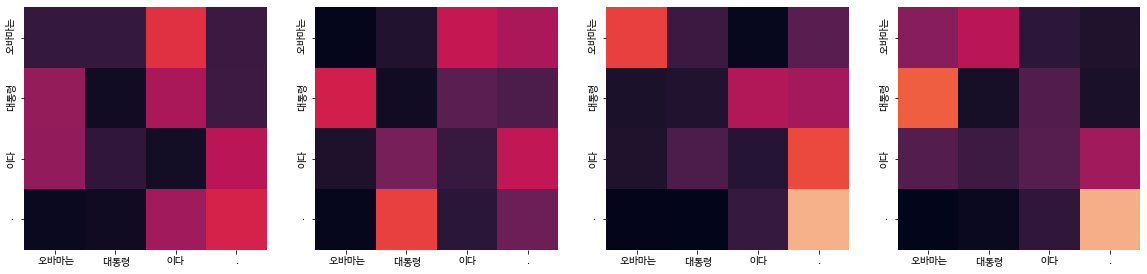

Encoder Layer 2


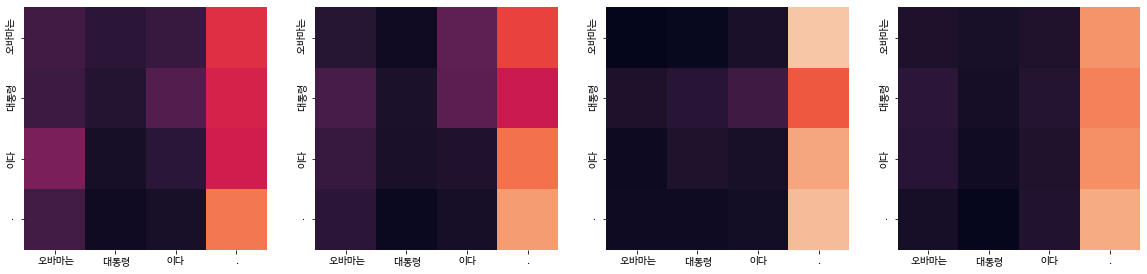

Decoder Self Layer 1


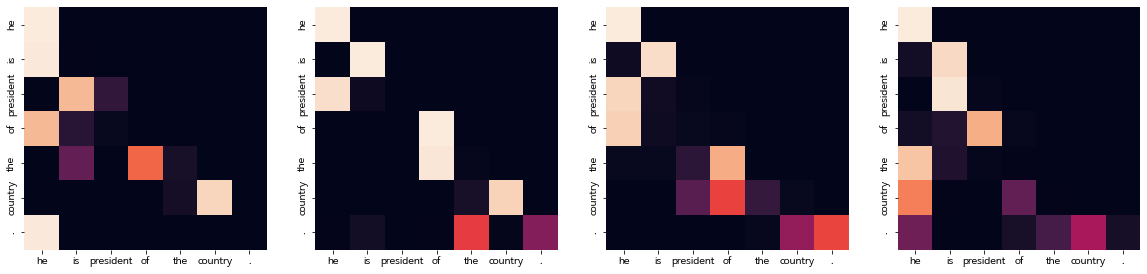

Decoder Src Layer 1


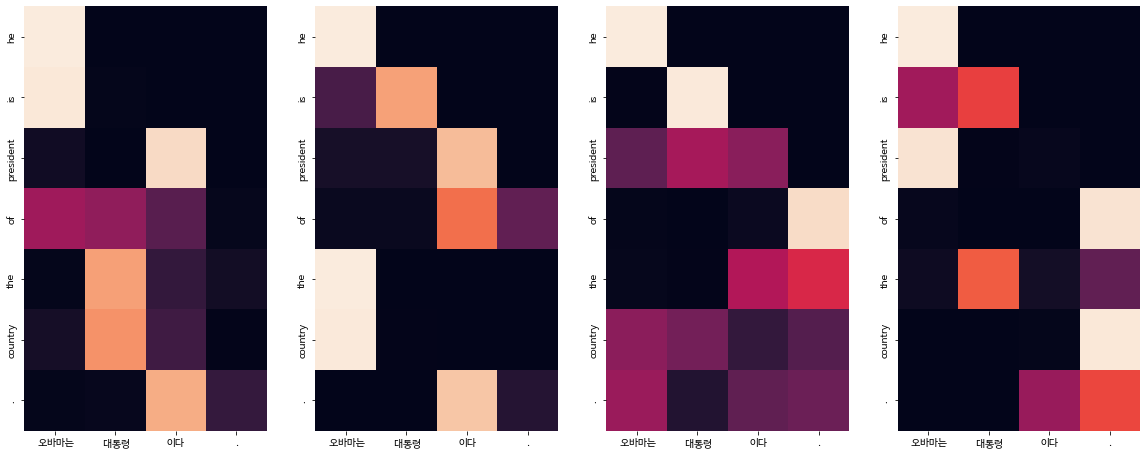

Decoder Self Layer 2


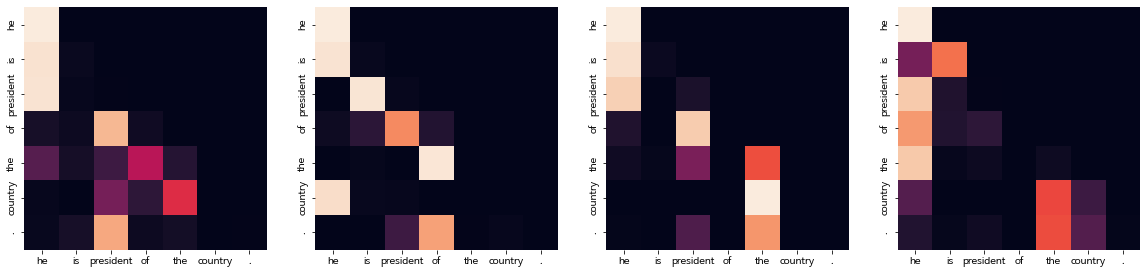

Decoder Src Layer 2


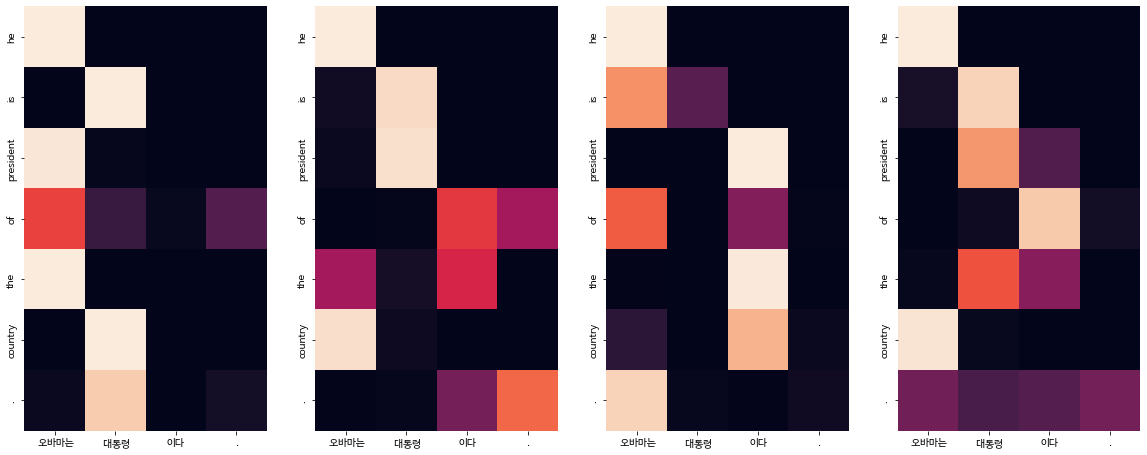

Input: 시민들은 도시 속에 산다.
Output: they took a mountain out of the mountain .
Encoder Layer 1


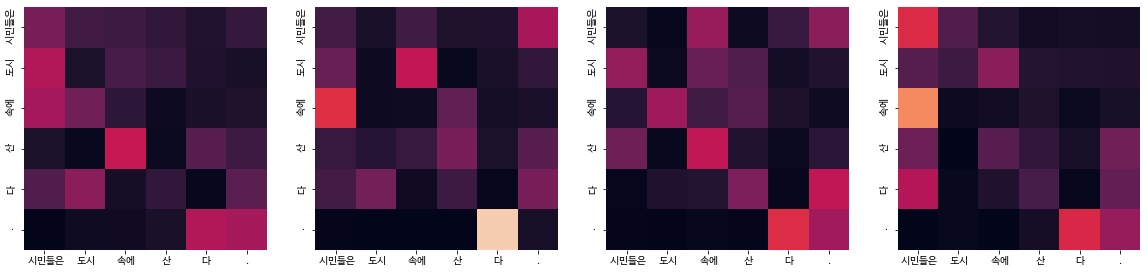

Encoder Layer 2


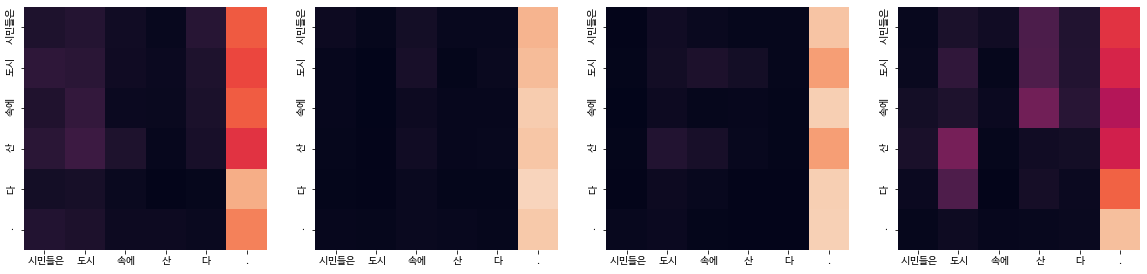

Decoder Self Layer 1


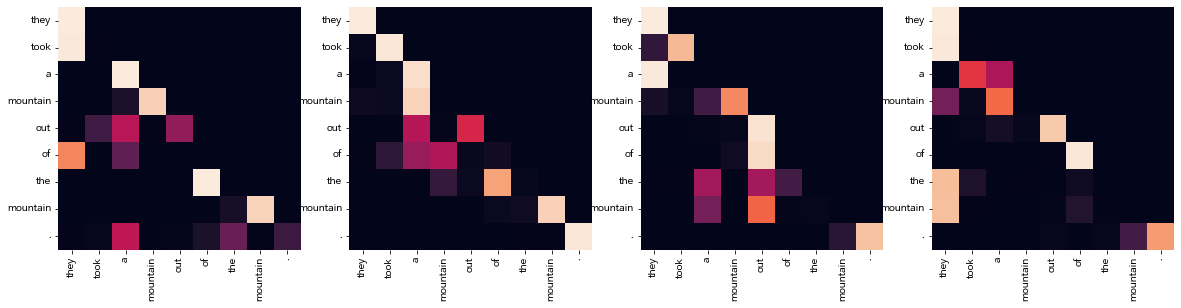

Decoder Src Layer 1


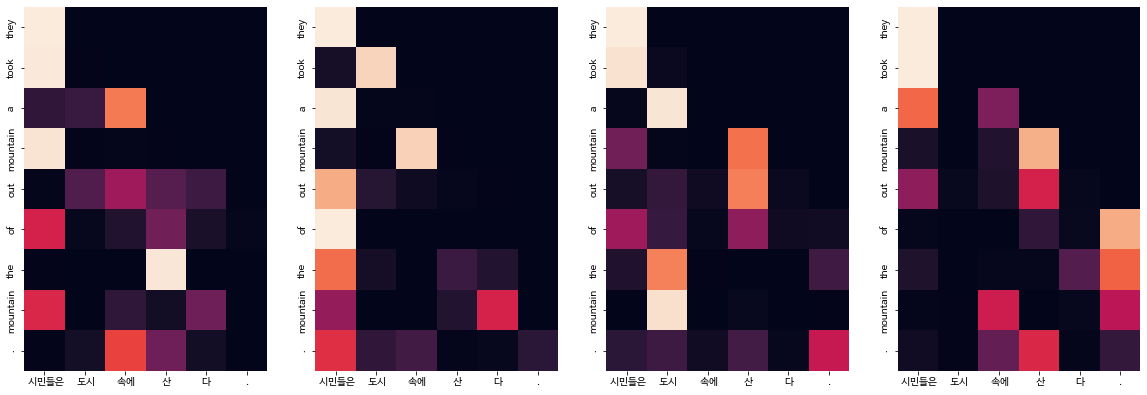

Decoder Self Layer 2


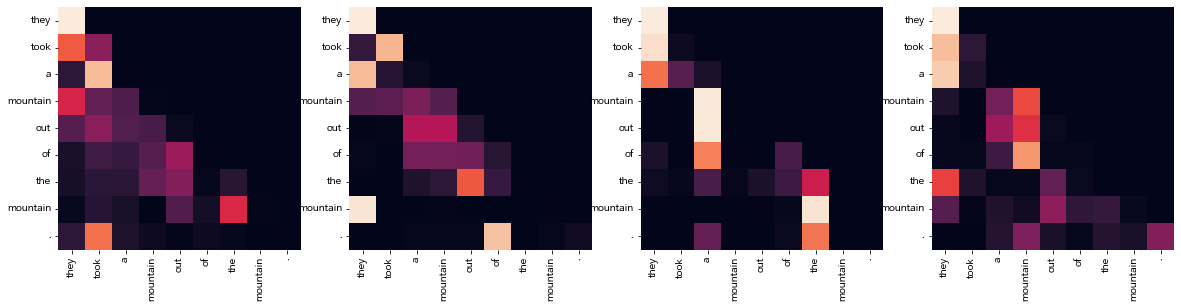

Decoder Src Layer 2


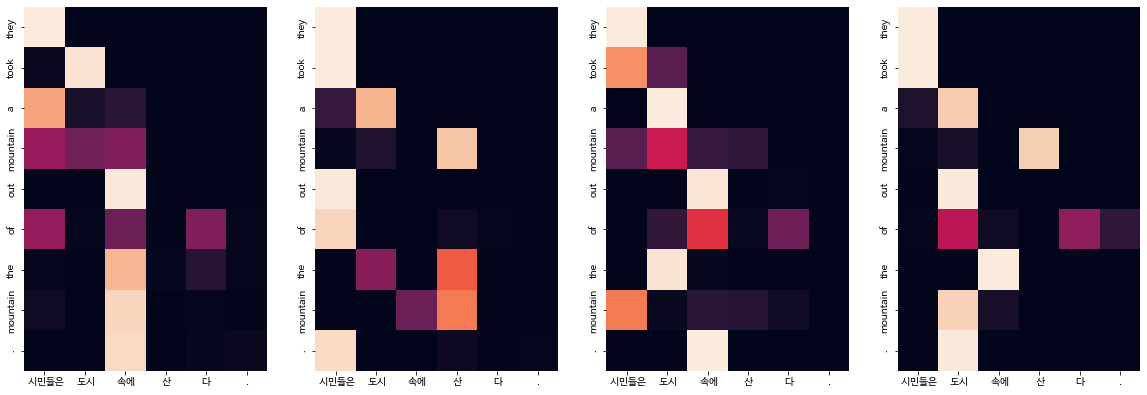

Input: 커피는 필요 없다.
Output: or if you need a person to be
Encoder Layer 1


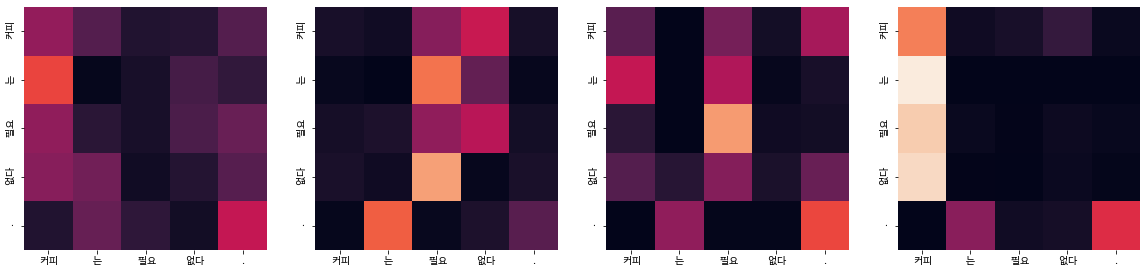

Encoder Layer 2


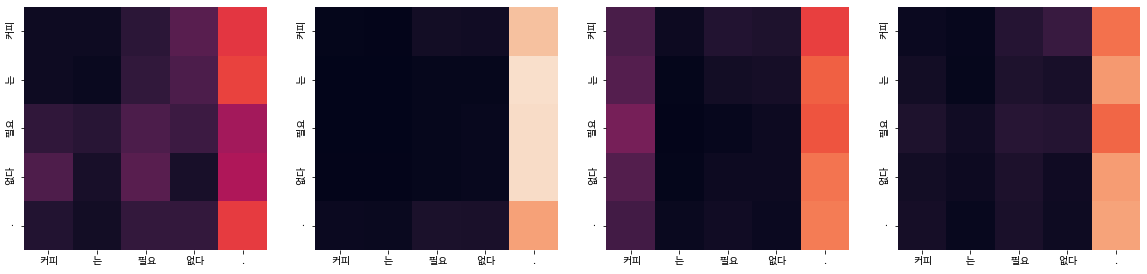

Decoder Self Layer 1


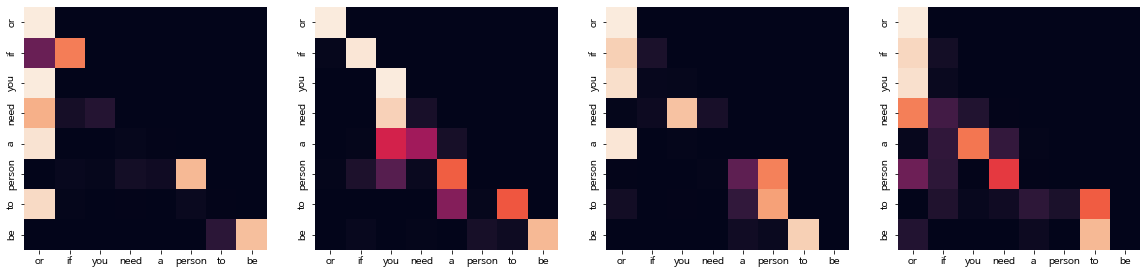

Decoder Src Layer 1


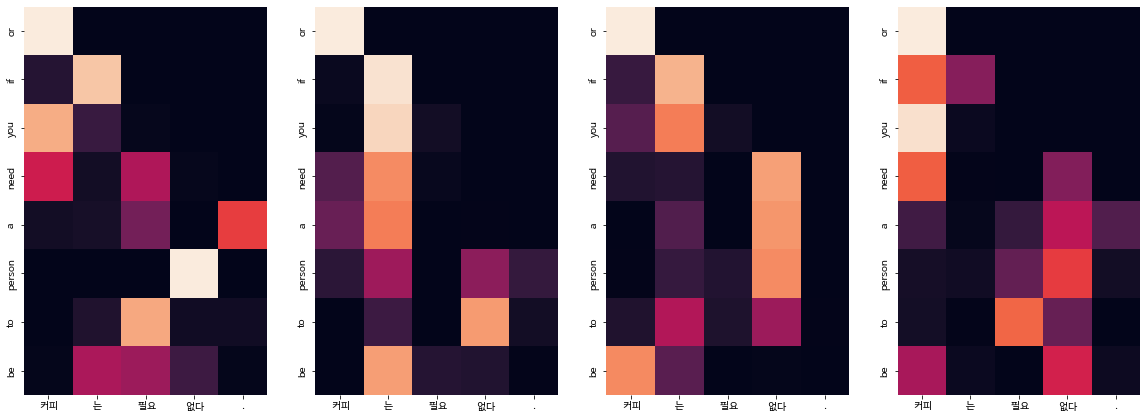

Decoder Self Layer 2


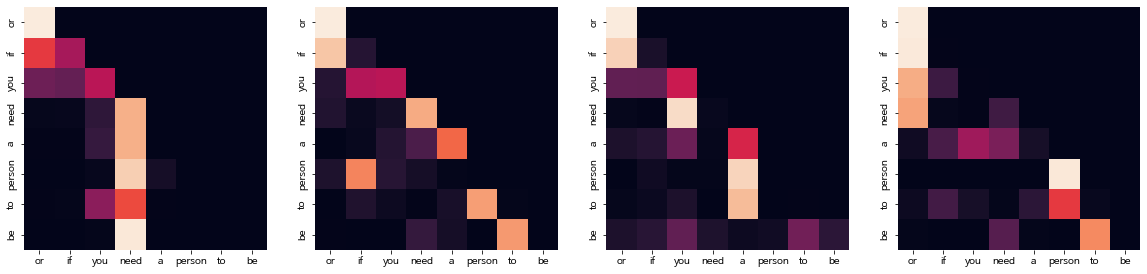

Decoder Src Layer 2


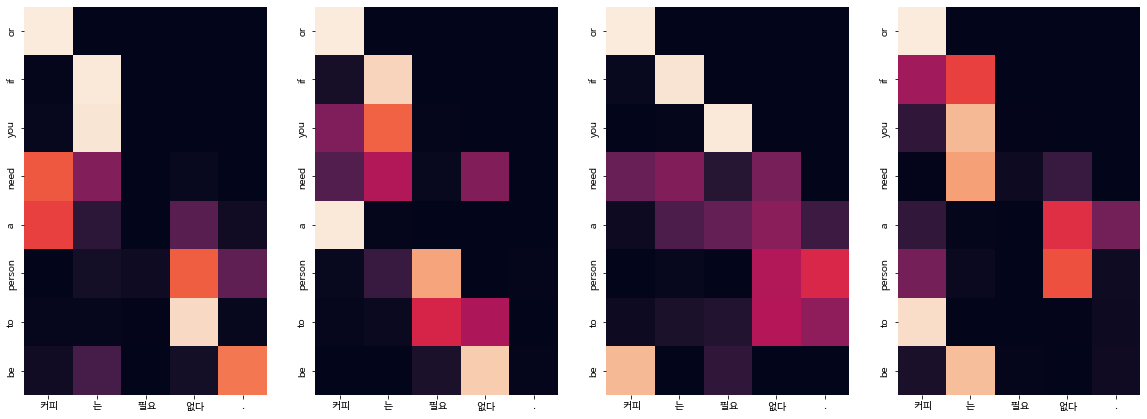

Input: 일곱 명의 사망자가 발생했다.
Output: seven people were killed .
Encoder Layer 1


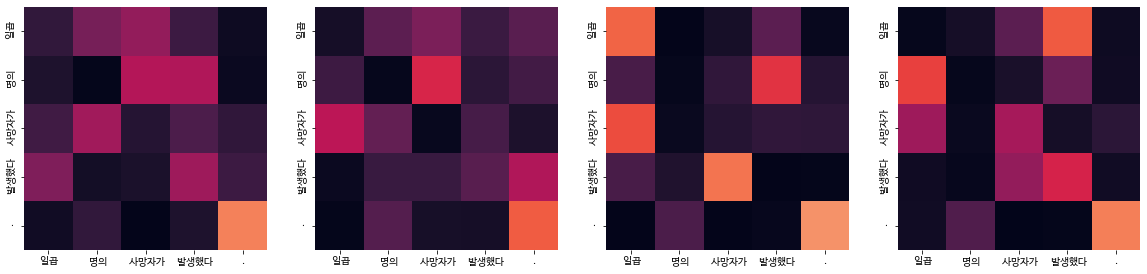

Encoder Layer 2


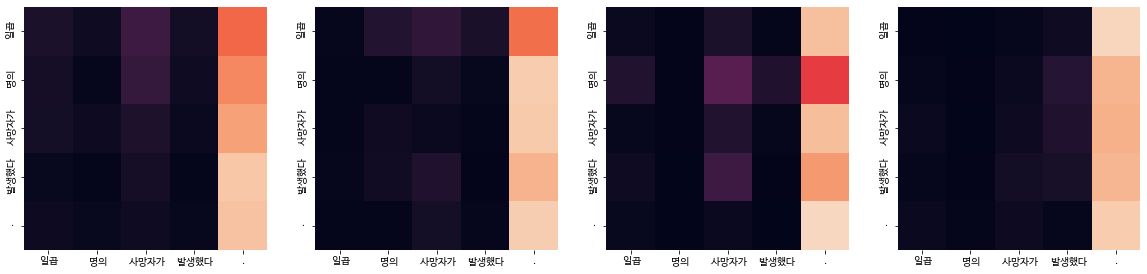

Decoder Self Layer 1


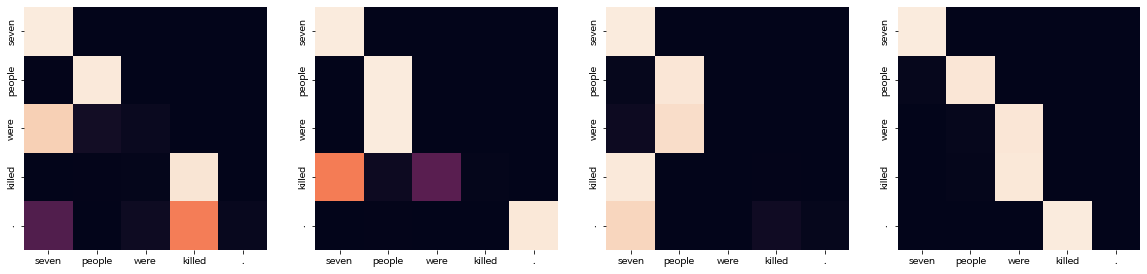

Decoder Src Layer 1


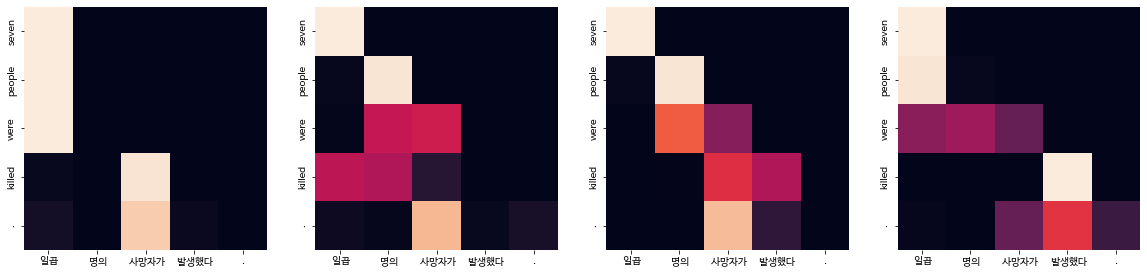

Decoder Self Layer 2


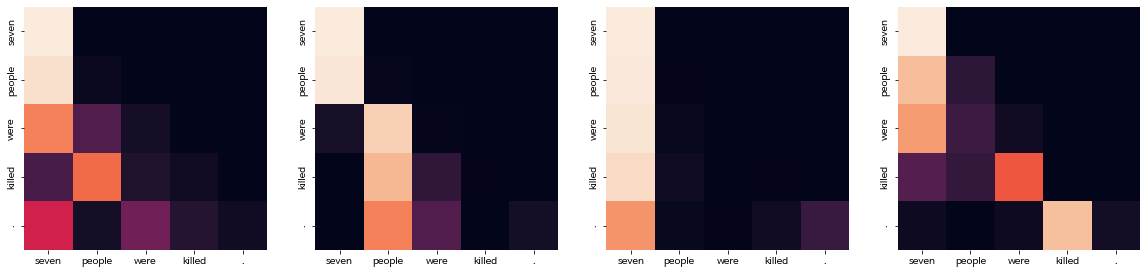

Decoder Src Layer 2


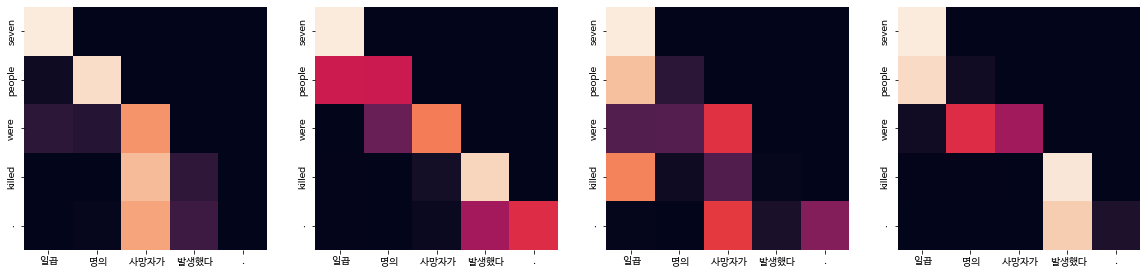

In [132]:
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager.findfont(font)

for example in examples:
    translate(example, transformer, ko_tokenizer, en_tokenizer,plot_attention=True)

# 평가항목

|Num|평가문항	|상세기준|
|:---:|:---|:---|
|1.| 번역기 모델 학습에 필요한 텍스트 데이터 전처리가 잘 이루어졌다.	|데이터 정제, SentencePiece를 활용한 토큰화 및 데이터셋 구축의 과정이 지시대로 진행되었다.|
|2. |Transformer 번역기 모델이 정상적으로 구동된다.	|Transformer 모델의 학습과 추론 과정이 정상적으로 진행되어, 한-영 번역기능이 정상 동작한다.|
|3.| 테스트 결과 의미가 통하는 수준의 번역문이 생성되었다.	|제시된 문장에 대한 그럴듯한 영어 번역문이 생성되며, 시각화된 Attention Map으로 결과를 뒷받침한다.|